In [46]:
%matplotlib inline
from __future__ import print_function, division

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import sqlalchemy
from sqlalchemy.orm import sessionmaker

from star_diffim_correlation import SourceDetectionCorrelation as SDC

In [74]:
engine = sqlalchemy.create_engine('sqlite:///star_diffim.sqlite3')

SessionFactory = sessionmaker()
SessionFactory.configure(bind=engine)
session = SessionFactory()

In [78]:
def make_normalized_histogram(filtered_query, bins):
    H = zeros(len(bins) - 1)
    for source in filtered_query:
        source_H, _ = np.histogram(source.dist_array(), bins=bins)
        H += source_H
        
    nstars = filtered_query.count()
    norm = pi*bins[1:]**2 - pi*bins[:-1]**2
    normalized_H = H/norm/float(nstars)
    return normalized_H


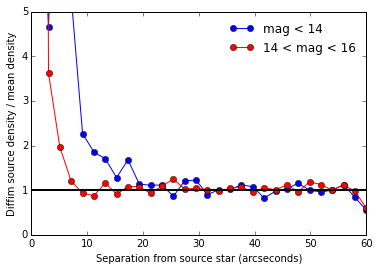

In [87]:
bins = linspace(0,120,60)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# 60 chips. 0.045 sq deg per chip. 3600**2 sq arcsec per sq deg
# 20e3 detections is what I get from counting on visit 197391
mean_density = 20e3 / (60 * 0.045) / 3600.0**2

filtered_query = session.query(SDC).filter(SDC.source_mag < 14)
normalized_H = make_normalized_histogram(filtered_query, bins)
plt.plot(bin_centers, normalized_H/mean_density, 'bo-', label="mag < 14")

filtered_query = session.query(SDC).filter(SDC.source_mag > 14, SDC.source_mag < 16)
normalized_H = make_normalized_histogram(filtered_query, bins)
plt.plot(bin_centers, normalized_H/mean_density, 'ro-', label="14 < mag < 16")

plt.axhline(1, color='k', ls='-', lw=2)
plt.ylim(0,5)
plt.xlim(0,60)
plt.xlabel("Separation from source star (arcseconds)")
plt.ylabel("Diffim source density / mean density")
plt.legend(frameon=False, loc="upper right")